In [1]:
import numpy as np
import pandas as pd
from functools import reduce
import os
import statsmodels.api as sm

# Market Data for China

In [69]:
df_CRSP_market_daily=pd.read_excel('../data/Chinese_Stock_Data/000985_market_index.xlsx',\
index_col=0,parse_dates=True)
df_CRSP_market_daily = df_CRSP_market_daily.iloc[:-1,:]
df_CRSP_market_daily.columns=['Name','Date','Open','High','Low','Close','Volume','Dollar_Volume']
df_CRSP_market_daily.index.name='Ticker'
df_CRSP_market_daily = df_CRSP_market_daily.set_index(keys='Date')
df_CRSP_market_daily.index= pd.to_datetime(df_CRSP_market_daily.index)
df_CRSP_market_daily['vwretd']=(np.log(df_CRSP_market_daily[['Close']])-np.log(df_CRSP_market_daily[['Close']]).shift(1))
df_CRSP_market_daily = df_CRSP_market_daily.iloc[1:]

In [70]:
df_CRSP_market_daily.tail()

,Name,Open,High,Low,Close,Volume,Dollar_Volume,vwretd
Date,,,,,,,,
2021-02-02,中证全指,5677.29,5744.39,5650.09,5742.20,5.620186e+10,8.347771e+11,0.013043
2021-02-03,中证全指,5740.97,5764.51,5701.93,5706.48,6.070058e+10,8.851988e+11,-0.006240
2021-02-04,中证全指,5679.01,5718.71,5592.22,5660.39,6.150797e+10,8.755073e+11,-0.008110
2021-02-05,中证全指,5677.58,5710.18,5625.09,5628.43,5.736290e+10,8.269457e+11,-0.005662
2021-02-08,中证全指,5645.18,5718.56,5612.92,5702.53,4.976300e+10,7.445762e+11,0.013079


In [4]:
df_CRSP_riskfree_monthly=pd.read_csv('../data/CRSP/CRSP Risk Free Rates.csv',\
index_col=4,parse_dates=True)

In [5]:
df_CRSP_riskfree_monthly

,KYTREASNOX,TIDXFAM,TTERMTYPE,TTERMLBL,RMTREASNO,RMCRSPID,TMBIDYTM,TMASKYTM,TMYTM,TMDURATN
MCALDT,,,,,,,,,,
2000-01-31,2000001,RISKFREE,30,CRSP Risk Free Rates - 1-Month (Nominal),203118,20000302.4,5.3900,5.3800,5.3900,31
2000-02-29,2000001,RISKFREE,30,CRSP Risk Free Rates - 1-Month (Nominal),203122,20000330.4,5.3200,5.3100,5.3100,30
2000-03-31,2000001,RISKFREE,30,CRSP Risk Free Rates - 1-Month (Nominal),203133,20000504.4,5.8600,5.8500,5.8600,34
2000-04-28,2000001,RISKFREE,30,CRSP Risk Free Rates - 1-Month (Nominal),203141,20000601.4,5.2800,5.2600,5.2700,34
2000-05-31,2000001,RISKFREE,30,CRSP Risk Free Rates - 1-Month (Nominal),203149,20000706.4,4.6800,4.6700,4.6700,36
...,...,...,...,...,...,...,...,...,...,...
2020-08-31,2000002,RISKFREE,90,CRSP Risk Free Rates - 3-Month (Nominal),207541,20201127.4,0.1060,0.0963,0.1010,88
2020-09-30,2000002,RISKFREE,90,CRSP Risk Free Rates - 3-Month (Nominal),207571,20201229.4,0.0913,0.0811,0.0862,90
2020-10-30,2000002,RISKFREE,90,CRSP Risk Free Rates - 3-Month (Nominal),207468,20210128.4,0.0913,0.0862,0.0887,90


In [6]:
df_AQR_risk_free_daily=pd.read_excel('../data/AQR Data/Betting Against Beta Equity Factors Daily.xlsx',\
sheet_name='RF',header=18,index_col=0,parse_dates=True)

In [7]:
df_AQR_risk_free_daily

,Risk Free Rate
DATE,
1926-07-31,0.000106
1926-08-02,0.000120
1926-08-03,0.000120
1926-08-04,0.000120
1926-08-05,0.000120
...,...
2020-12-25,0.000003
2020-12-28,0.000003
2020-12-29,0.000003


# Single Stock Data

In [202]:
df_china_stock_all=pd.read_csv('../data/Chinese_Stock_Data/close_20050101_to_20201231.csv',header=0
                                   ,index_col=0,parse_dates=True)
df_ticker_mapping = pd.read_csv('../data/Chinese_Stock_Data/metadata.csv',usecols=[0,2,3,4,5])
df_ticker_mapping= df_ticker_mapping.rename(columns={'Unnamed: 0':'code'})
code = [i[:-5] for i in df_ticker_mapping.code.values]
df_ticker_mapping.code= code
mapping_result=[df_ticker_mapping.loc[df_ticker_mapping.code==i, 'name'].values[0] 
                for i in df_china_stock_all.columns.values]


In [203]:
#df_china_stock_all.columns=mapping_result

In [204]:
df_china_stock_all

,000001,000002,000004,000005,000006,000007,000008,000009,000010,000011,...,688668,688678,688679,688686,688698,688699,688777,688788,688981,689009
2005-01-04,1.47,0.98,5.15,1.29,0.49,1.50,0.79,1.08,1.10,2.09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-01-05,1.46,1.02,5.26,1.32,0.50,1.55,0.81,1.10,1.14,2.16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-01-06,1.47,1.01,5.28,1.32,0.50,1.54,0.81,1.10,1.15,2.14,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-01-07,1.47,1.02,5.26,1.38,0.55,1.60,0.83,1.12,1.16,2.18,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-01-10,1.49,1.01,5.29,1.42,0.57,1.77,0.87,1.15,1.21,2.20,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-25,18.04,28.10,21.71,2.52,5.65,8.52,2.56,7.59,3.91,11.83,...,31.70,25.65,19.02,NaN,NaN,59.20,98.30,183.00,53.43,75.10
2020-12-28,18.85,28.42,20.45,2.49,5.50,8.50,2.51,7.35,3.59,11.48,...,29.68,22.90,16.07,NaN,NaN,55.90,102.35,146.40,52.03,80.10
2020-12-29,19.17,28.52,20.66,2.50,5.53,8.60,2.51,7.33,3.95,11.85,...,29.89,22.46,15.55,NaN,20.02,54.01,98.41,128.11,52.53,77.46
2020-12-30,19.20,28.38,20.47,2.49,5.54,7.74,2.52,7.58,3.97,12.16,...,29.91,22.24,15.74,NaN,19.35,54.20,99.98,133.00,56.47,80.91


In [180]:
df_one_day_one_stock = df_china_stock_all[['SHGF']]
df_one_day_one_stock.index.name=df_one_day_one_stock.columns[0]
df_one_day_one_stock.columns=['Close']


ValueError: Length mismatch: Expected axis has 4 elements, new values have 1 elements

In [143]:
df_one_day_one_stock.tail()

,Close
PAYH,
2020-12-25,18.04
2020-12-28,18.85
2020-12-29,19.17
2020-12-30,19.20
2020-12-31,19.34


In [144]:
df_one_day_one_stock.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3889 entries, 2005-01-04 to 2020-12-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   3889 non-null   float64
dtypes: float64(1)
memory usage: 60.8 KB


In [145]:
df_return=(np.log(df_one_day_one_stock[['Close']])-np.log(df_one_day_one_stock[['Close']]).shift(1))[1:]
df_return.columns=['total_ret']

## Merge all required data

In [146]:
dfs=[df_return,df_AQR_risk_free_daily,df_CRSP_market_daily[['vwretd']]]

In [147]:
df_one_stock_return_merged=reduce(lambda x,y:pd.merge(x,y,left_index=True, right_index=True),dfs)

In [148]:
df_one_stock_return_merged.tail()

,total_ret,Risk Free Rate,vwretd
2020-12-25,-0.012121,0.000003,0.009291
2020-12-28,0.043921,0.000003,-0.000348
2020-12-29,0.016834,0.000003,-0.005372
2020-12-30,0.001564,0.000003,0.012718
2020-12-31,0.007265,0.000003,0.017494


In [149]:
df_one_stock_return_merged.total_ret =df_one_stock_return_merged.total_ret-\
df_one_stock_return_merged['Risk Free Rate']
df_one_stock_return_merged.vwretd =df_one_stock_return_merged.vwretd-\
df_one_stock_return_merged['Risk Free Rate'] 

In [150]:
df_one_stock_return_merged=df_one_stock_return_merged.rename(columns={'Risk Free Rate':'rf','vwretd':'mkt',
                                                                     'total_ret':'ret'})

In [151]:
df_one_stock_return_merged.tail()

,ret,rf,mkt
2020-12-25,-0.012125,0.000003,0.009287
2020-12-28,0.043918,0.000003,-0.000351
2020-12-29,0.016830,0.000003,-0.005375
2020-12-30,0.001561,0.000003,0.012714
2020-12-31,0.007262,0.000003,0.017491


## Beta Calculation

### ex ante beta

In [152]:
# Estimate rolling 5 year(1260 trading days) correlations with 
# minimum 750 non-missing datapoints
df_one_stock_return_merged['corr'] = pd.DataFrame(df_one_stock_return_merged['ret'].\
                                                      rolling(1260, min_periods=750).\
             corr(df_one_stock_return_merged['mkt']))
df_one_stock_return_merged['corr'] = df_one_stock_return_merged['corr'].shift(1)

In [153]:
df_one_stock_return_merged

,ret,rf,mkt,corr
2005-01-05,-0.006913,0.000087,0.012762,NaN
2005-01-06,0.006739,0.000087,-0.009761,NaN
2005-01-07,-0.000087,0.000087,0.002017,NaN
2005-01-10,0.013427,0.000087,0.009327,NaN
2005-01-11,-0.000087,0.000087,0.002722,NaN
...,...,...,...,...
2020-12-25,-0.012125,0.000003,0.009287,0.228877
2020-12-28,0.043918,0.000003,-0.000351,0.228425
2020-12-29,0.016830,0.000003,-0.005375,0.226831
2020-12-30,0.001561,0.000003,0.012714,0.226756


<AxesSubplot:title={'center':'AAME Total Return'}>

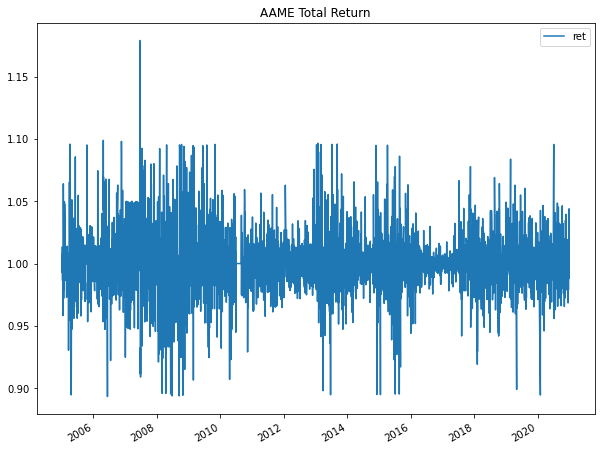

In [154]:
(df_one_stock_return_merged[['ret']]+1).plot(figsize=(10,8),title='AAME Total Return')

In [155]:
(df_one_stock_return_merged[['ret']]+1).sort_values(by='ret')

,ret
2006-06-13,0.893201
2006-06-12,0.893327
2008-09-16,0.893732
2008-06-27,0.893736
2008-10-27,0.894232
...,...
2013-09-09,1.095919
2013-01-28,1.096584
2006-11-21,1.098113
2006-04-26,1.098910


In [156]:
df_log_return_three_days=np.log(df_one_stock_return_merged[['ret','mkt']]+1).rolling(window=3).sum()

In [157]:
df_log_return_three_days['corr'] = pd.DataFrame(df_log_return_three_days['ret'].\
                                                      rolling(1260, min_periods=750).\
             corr(df_log_return_three_days['mkt']))
df_log_return_three_days['corr'] = df_log_return_three_days['corr'].shift(1)

<AxesSubplot:>

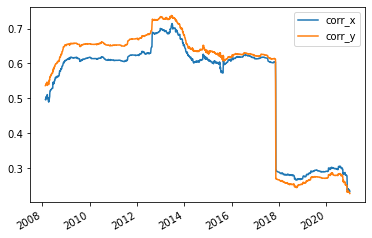

In [158]:
pd.merge(df_log_return_three_days['corr'],df_one_stock_return_merged['corr'],left_index=True,
        right_index=True).dropna().plot()

In [159]:
# use three-day log returns to control for nonsynchronous trading
df_one_stock_return_merged['corr']=df_log_return_three_days['corr']

In [160]:
df_one_stock_return_merged

,ret,rf,mkt,corr
2005-01-05,-0.006913,0.000087,0.012762,NaN
2005-01-06,0.006739,0.000087,-0.009761,NaN
2005-01-07,-0.000087,0.000087,0.002017,NaN
2005-01-10,0.013427,0.000087,0.009327,NaN
2005-01-11,-0.000087,0.000087,0.002722,NaN
...,...,...,...,...
2020-12-25,-0.012125,0.000003,0.009287,0.236135
2020-12-28,0.043918,0.000003,-0.000351,0.235260
2020-12-29,0.016830,0.000003,-0.005375,0.233155
2020-12-30,0.001561,0.000003,0.012714,0.232318


In [161]:
# same for rolling std, but with 1 year horizon (252 trading days) with 
# minimum 120 non-missing datapoints
df_one_stock_return_merged['i_std'] = pd.DataFrame(df_one_stock_return_merged['ret'].\
                                                      rolling(252, min_periods=120).std())
df_one_stock_return_merged['i_std'] = df_one_stock_return_merged['i_std'].shift(1)

df_one_stock_return_merged['mkt_std'] = pd.DataFrame(df_one_stock_return_merged['mkt'].\
                                                      rolling(252, min_periods=120).std())
df_one_stock_return_merged['mkt_std'] = df_one_stock_return_merged['mkt_std'].shift(1)

In [162]:
df_one_stock_return_merged

,ret,rf,mkt,corr,i_std,mkt_std
2005-01-05,-0.006913,0.000087,0.012762,NaN,NaN,NaN
2005-01-06,0.006739,0.000087,-0.009761,NaN,NaN,NaN
2005-01-07,-0.000087,0.000087,0.002017,NaN,NaN,NaN
2005-01-10,0.013427,0.000087,0.009327,NaN,NaN,NaN
2005-01-11,-0.000087,0.000087,0.002722,NaN,NaN,NaN
...,...,...,...,...,...,...
2020-12-25,-0.012125,0.000003,0.009287,0.236135,0.021367,0.014817
2020-12-28,0.043918,0.000003,-0.000351,0.235260,0.021379,0.014826
2020-12-29,0.016830,0.000003,-0.005375,0.233155,0.021514,0.014825
2020-12-30,0.001561,0.000003,0.012714,0.232318,0.021536,0.014829


In [163]:

#drop all the rows where in ANY column there is a NAN value
df_one_stock_return_merged = df_one_stock_return_merged.dropna(how='any')
# Estimation betas like on page 8 in eq (14) in the paper
df_one_stock_return_merged['beta_est'] = df_one_stock_return_merged['corr']*\
df_one_stock_return_merged['i_std'].div(df_one_stock_return_merged['mkt_std'])
#Shrink the betas to make them less noisy eq(15)
df_one_stock_return_merged['beta_est'] = 0.6*df_one_stock_return_merged['beta_est'] + 0.4

/Users/lijinyang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/Users/lijinyang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [172]:
df_one_stock_return_merged

,ret,rf,mkt,corr,i_std,mkt_std,beta_est
2008-02-18,0.012139,0.000077,0.023085,0.497182,0.035646,0.024596,0.832329
2008-02-19,0.020678,0.000077,0.020749,0.496995,0.035540,0.024621,0.830434
2008-02-20,-0.069456,0.000077,-0.017744,0.496799,0.035403,0.024308,0.834130
2008-02-21,-0.022339,0.000077,-0.001048,0.495763,0.035602,0.024342,0.835053
2008-02-22,-0.053618,0.000077,-0.032073,0.495265,0.035485,0.024235,0.835106
...,...,...,...,...,...,...,...
2020-12-25,-0.012125,0.000003,0.009287,0.236135,0.021367,0.014817,0.604313
2020-12-28,0.043918,0.000003,-0.000351,0.235260,0.021379,0.014826,0.603550
2020-12-29,0.016830,0.000003,-0.005375,0.233155,0.021514,0.014825,0.603010
2020-12-30,0.001561,0.000003,0.012714,0.232318,0.021536,0.014829,0.602435


<AxesSubplot:>

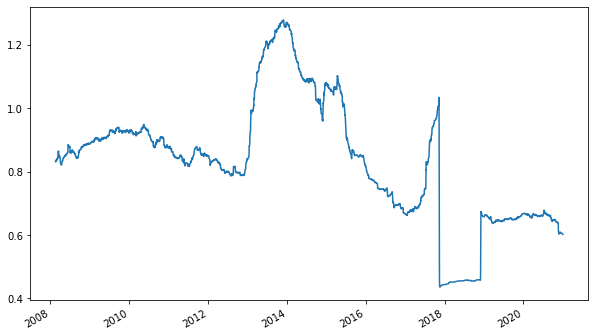

In [164]:
df_one_stock_return_merged.beta_est.plot(figsize=(10,6))

# All stocks

## First trial, not available for large dataset with daily data

In [50]:
df_all=pd.DataFrame(columns=['Ticker','Close'])

In [444]:
for filename in os.listdir(data_folder_path)[:500]:
    if 'txt' in filename:
        df_one_day_one_stock=pd.read_csv(data_folder_path+filename,header=None,\
            names=['Date','Open','High','Low','Close','Volume'],index_col=0,parse_dates=True)
        df_return=(np.log(df_one_day_one_stock)-np.log(df_one_day_one_stock).shift(1))[1:][['Close']]
        df_return['Ticker'] = ''.join(filename.split('.')[:-1])
        
        df_all=df_all.append(df_return)

In [445]:
df_all = df_all.rename(columns={'Close':'total_ret'})

In [446]:
df_all

,Ticker,total_ret
2020-12-22,CONXW,0.117319
2020-12-23,CONXW,0.061930
2020-12-24,CONXW,-0.068993
2020-12-28,CONXW,-0.011050
2020-12-29,CONXW,-0.011173
...,...,...
2020-12-24,BSBK,-0.011924
2020-12-28,BSBK,-0.006565
2020-12-29,BSBK,-0.012148
2020-12-30,BSBK,0.006645


In [447]:
dfs=[df_all,df_AQR_risk_free_daily,df_CRSP_market_daily[['vwretd']]]

In [448]:
df_all_stock_return_merged=reduce(lambda x,y:pd.merge(x,y,left_index=True, right_index=True),dfs)

In [450]:
df_all_stock_return_merged.total_ret =df_all_stock_return_merged.total_ret-\
df_all_stock_return_merged['Risk Free Rate']
df_all_stock_return_merged.vwretd =df_all_stock_return_merged.vwretd-\
df_all_stock_return_merged['Risk Free Rate'] 

In [451]:
df_all_stock_return_merged=df_all_stock_return_merged.rename(columns={'Risk Free Rate':'rf','vwretd':'mkt',
                                                                     'total_ret':'ret'})

In [452]:
df_all_stock_return_merged

,Ticker,ret,rf,mkt
2005-01-04,GTSI,-0.053725,0.000087,-0.012892
2005-01-04,AROW,-0.012510,0.000087,-0.012892
2005-01-04,EPIQ,-0.017776,0.000087,-0.012892
2005-01-04,ARMH,0.004776,0.000087,-0.012892
2005-01-04,KMB,0.000749,0.000087,-0.012892
...,...,...,...,...
2020-12-31,KF,0.002975,0.000003,0.003553
2020-12-31,OAS,0.007804,0.000003,0.003553
2020-12-31,AFGE,-0.001455,0.000003,0.003553
2020-12-31,POWL,0.006624,0.000003,0.003553


In [453]:

# define function to estimate rolling 5 year(60 month) correlations with minimum 36 non-missing datapoints
def roll_corr(x):
    return pd.DataFrame(x['ret'].rolling(60, min_periods=36).corr(x['mkt']))


#same for rolling std, but with 1 year horizon
def roll_var(x):
    return pd.DataFrame(x['ret'].rolling(252, min_periods=120).std())

Daily data is too much, need to change a method for alpha calculation

## Second Trial

### Focus on One Day

In [167]:
df_china_stock_all['PAYH']

PAYH
2005-01-04     1.47
2005-01-05     1.46
2005-01-06     1.47
2005-01-07     1.47
2005-01-10     1.49
              ...  
2020-12-25    18.04
2020-12-28    18.85
2020-12-29    19.17
2020-12-30    19.20
2020-12-31    19.34
Name: PAYH, Length: 3889, dtype: float64

In [215]:
def get_ex_ante_beta(code, df_risk_free,df_market):
    df_one_day_one_stock = df_china_stock_all[[code]]
    df_one_day_one_stock.columns=['Close']

    with np.errstate(divide='raise'):
        try:
            df_return=(np.log(df_one_day_one_stock[['Close']])-np.log(df_one_day_one_stock[['Close']]).shift(1))[1:]
        except FloatingPointError:
            bad_tickers.append(code)
            return pd.DataFrame()
    df_return.columns=['total_ret']
    dfs=[df_return,df_risk_free,df_market]
    df=reduce(lambda x,y:pd.merge(x,y,left_index=True, right_index=True),dfs)
    df.total_ret =df.total_ret-df['Risk Free Rate']
    df.vwretd =df.vwretd-df['Risk Free Rate'] 
    df=df.rename(columns={'Risk Free Rate':'rf','vwretd':'mkt','total_ret':'ret'})
    with np.errstate(invalid='raise'):
        try:
            df_log_return_three_days=np.log(df[['ret','mkt']]+1).rolling(window=3).sum()
        except FloatingPointError:
            df_log_return_three_days=(df[['ret','mkt']]+1).rolling(window=3).apply(np.prod, raw=True)-1
            bad_tickers.append(code)
    
    df_log_return_three_days['corr'] = pd.DataFrame(df_log_return_three_days['ret'].\
                                                      rolling(1260, min_periods=750).\
             corr(df_log_return_three_days['mkt']))
    df_log_return_three_days['corr'] = df_log_return_three_days['corr'].shift(1)
    df['corr']=df_log_return_three_days['corr']
    df['i_std'] = pd.DataFrame(df['ret'].rolling(252, min_periods=120).std())
    df['i_std'] = df['i_std'].shift(1)
    df['mkt_std'] = pd.DataFrame(df['mkt'].rolling(252, min_periods=120).std())
    df['mkt_std'] = df['mkt_std'].shift(1)
    df = df.dropna(how='any')
    df['beta_est'] = df['corr']*df['i_std'].div(df['mkt_std'])
    df['beta_est'] = 0.6*df['beta_est'] + 0.4
    return df[['ret','beta_est']]

In [209]:
get_ex_ante_beta(tickers[12],df_AQR_risk_free_daily,df_CRSP_market_daily[['vwretd']])

,ret,beta_est
2008-02-18,0.004674,0.960523
2008-02-19,0.018703,0.959652
2008-02-20,-0.028381,0.962793
2008-02-21,0.023565,0.962488
2008-02-22,-0.028515,0.965263
...,...,...
2020-12-25,-0.012349,0.923485
2020-12-28,-0.036371,0.923106
2020-12-29,0.039465,0.920150
2020-12-30,0.003088,0.918858


In [210]:
bad_tickers=[]

In [211]:
tickers=df_china_stock_all.columns.values

In [216]:
counter=0
for ticker in tickers:
    print(ticker)
    df_=get_ex_ante_beta(ticker,df_AQR_risk_free_daily,df_CRSP_market_daily[['vwretd']])
    if not len(df_)==0:
        counter+=1
        df_.to_pickle('../output/China/'+ticker+'.pickle')

000001
000002
000004
000005
000006
000007
000008
000009
000010
000011
000012
000014
000016
000017
000018
000019
000020
000021
000022
000023
000024
000025
000026
000027
000028
000029
000030
000031
000032
000033
000034
000035
000036
000037
000038
000039
000040
000042
000043
000045
000046
000048
000049
000050
000055
000056
000058
000059
000060
000061
000062
000063
000065
000066
000068
000069
000070
000078
000088
000089
000090
000096
000099
000100
000150
000151
000153
000155
000156
000157
000158
000159
000166
000301
000333
000338
000400
000401
000402
000403
000404
000406
000407
000408
000409
000410
000411
000413
000415
000416
000417
000418
000419
000420
000421
000422
000423
000425
000426
000428
000429
000430
000488
000498
000501
000502
000503
000504
000505
000506
000507
000509
000510
000511
000513
000514
000515
000516
000517
000518
000519
000520
000521
000522
000523
000524
000525
000526
000527
000528
000529
000530
000531
000532
000533
000534
000535
000536
000537
000538
000539
000540
000541

002682
002683
002684
002685
002686
002687
002688
002689
002690
002691
002692
002693
002694
002695
002696
002697
002698
002699
002700
002701
002702
002703
002705
002706
002707
002708
002709
002711
002712
002713
002714
002715
002716
002717
002718
002719
002721
002722
002723
002724
002725
002726
002727
002728
002729
002730
002731
002732
002733
002734
002735
002736
002737
002738
002739
002740
002741
002742
002743
002745
002746
002747
002748
002749
002750
002751
002752
002753
002755
002756
002757
002758
002759
002760
002761
002762
002763
002765
002766
002767
002768
002769
002770
002771
002772
002773
002774
002775
002776
002777
002778
002779
002780
002781
002782
002783
002785
002786
002787
002788
002789
002790
002791
002792
002793
002795
002796
002797
002798
002799
002800
002801
002802
002803
002805
002806
002807
002808
002809
002810
002811
002812
002813
002815
002816
002817
002818
002819
002820
002821
002822
002823
002824
002825
002826
002827
002828
002829
002830
002831
002832
002833
002835

300873
300875
300876
300877
300878
300879
300880
300881
300882
300883
300884
300885
300886
300887
300888
300889
300890
300891
300892
300893
300894
300895
300896
300897
300898
300899
300900
300901
300902
300903
300905
300906
300907
300908
300909
300910
300911
300912
300913
300915
300916
300917
300918
300919
300920
300921
300922
300923
300925
300999
600000
600001
600002
600003
600004
600005
600006
600007
600008
600009
600010
600011
600012
600015
600016
600017
600018
600019
600020
600021
600022
600023
600025
600026
600027
600028
600029
600030
600031
600033
600035
600036
600037
600038
600039
600048
600050
600051
600052
600053
600054
600055
600056
600057
600058
600059
600060
600061
600062
600063
600064
600065
600066
600067
600068
600069
600070
600071
600072
600073
600074
600075
600076
600077
600078
600079
600080
600081
600082
600083
600084
600085
600086
600087
600088
600089
600090
600091
600092
600093
600094
600095
600096
600097
600098
600099
600100
600101
600102
600103
600104
600105
600106

603088
603089
603090
603093
603095
603096
603098
603099
603100
603101
603103
603105
603106
603108
603109
603110
603111
603112
603113
603115
603116
603117
603118
603121
603123
603126
603127
603128
603129
603131
603133
603136
603138
603139
603155
603156
603157
603158
603159
603160
603161
603165
603166
603167
603168
603169
603177
603178
603179
603180
603181
603183
603185
603186
603187
603188
603189
603192
603195
603196
603197
603198
603199
603200
603203
603208
603212
603214
603217
603218
603220
603221
603222
603223
603225
603226
603227
603228
603229
603232
603233
603236
603238
603239
603256
603258
603259
603260
603266
603267
603268
603269
603277
603278
603279
603283
603286
603288
603289
603290
603297
603298
603299
603300
603301
603303
603305
603306
603308
603309
603311
603313
603315
603316
603317
603318
603319
603320
603321
603322
603323
603326
603327
603328
603329
603330
603331
603332
603333
603335
603336
603337
603338
603339
603345
603348
603351
603353
603355
603356
603357
603358
603359

In [218]:
#print('we have excluded {} tickers at the beginning'.format(len(tickers_to_remove)))
print('we have {} bad tickers left'.format(len(bad_tickers)))
print('we have {} tickers‘ beta outputted in total'.format(counter))

we have 41 bad tickers left
we have 3498 tickers‘ beta outputted in total


In [219]:
np.savetxt('../output/China/bad_tickers/bad_ticker_v1.txt',np.array(bad_tickers),
           delimiter=" ", fmt="%s") 

In [143]:
df_one_day_one_stock=pd.read_csv('../data/US Stocks Data/alpha_vantage_clean_all/AACG.txt',header=None,\
            names=['Date','Open','High','Low','Close','Volume'],index_col=0,parse_dates=True)

In [144]:
unite_dates_index=df_one_day_one_stock.index

In [145]:
unite_dates_index[0]

Timestamp('2008-01-29 00:00:00')

In [146]:
x = df_one_stock_return_merged['mkt'].copy()
x = sm.add_constant(x)
results = sm.OLS(df_one_stock_return_merged['ret'], x).fit(cov_type='HC1')

In [147]:
results.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Results: Ordinary least squares
=================================================================
Model:              OLS              Adj. R-squared:     0.002   
Dependent Variable: ret              AIC:                -65.5115
Date:               2021-02-24 00:20 BIC:                -57.4550
No. Observations:   415              Log-Likelihood:     34.756  
Df Model:           1                F-statistic:        1.552   
Df Residuals:       413              Prob (F-statistic): 0.214   
R-squared:          0.004            Scale:              0.049760
-------------------------------------------------------------------
            Coef.    Std.Err.      z      P>|z|     [0.025   0.975]
-------------------------------------------------------------------
const      -0.0031     0.0113   -0.2746   0.7836   -0.0252   0.0190
mkt         1.0435     0.8377    1.2457   0.2129   -0.5984   2.6855
-----------------------------------------------------------------
Omnibus:             41.353       Durbin-Watson:          2.342  
Prob(Omnibus):       0.000        Jarque-Bera (JB):       232.692
Skew:                0.009        Prob(JB):               0.000  
Kurtosis:            6.668        Condition No.:          72     
=================================================================

"""

# Portfolio ranking for one day

In [194]:
beta_unit_dates_index=pd.read_pickle('../data/Ex Ante Beta/AAPL.pickle').index

In [250]:
data_folder_path = '../data/Ex Ante Beta/'
filenames=os.listdir(data_folder_path)
filenames.sort()

In [251]:
all_tickers=[filename[:-7] for filename in filenames]

In [252]:
stock_beta_by_ticker_dict={}
for filename in filenames:
    if filename[:-7] not in tickers_to_remove:
        df_ = pd.read_pickle(data_folder_path+filename)
        stock_beta_by_ticker_dict[filename[:-7]]=df_

In [253]:
beta_unit_dates_index[0]

Timestamp('2007-12-31 00:00:00')

In [254]:
df_one_day_beta=pd.DataFrame(index=all_tickers,columns=['ex_ante_beta','ret'])

In [255]:
for filename in filenames:
    #print(filename)
    df_ = stock_beta_by_ticker_dict[filename[:-7]]
    if beta_unit_dates_index[0] in df_.index:
        _=df_.loc[beta_unit_dates_index[0]]
        df_one_day_beta.loc[df_one_day_beta.index==filename[:-7],'ex_ante_beta']=_.beta_est
        df_one_day_beta.loc[df_one_day_beta.index==filename[:-7],'ret']=_.ret

In [256]:
df_one_day_beta = df_one_day_beta.dropna()
df_one_day_beta['q']=df_one_day_beta.apply(lambda x: pd.qcut(x, 10, labels=range(1, 11))).ex_ante_beta
df_one_day_beta.q = df_one_day_beta.q.astype(np.int)
df_one_day_beta.ex_ante_beta = df_one_day_beta.ex_ante_beta.astype(np.float)
df_one_day_beta.ret = df_one_day_beta.ret.astype(np.float)

In [257]:
df_one_day_beta.groupby(['q']).mean()

,ex_ante_beta,ret
q,,
1,0.497781,0.006843
2,0.663813,0.002715
3,0.770406,-0.002543
4,0.846745,-0.002595
5,0.909149,-0.003503
6,0.968206,-0.003378
7,1.024075,-0.004795
8,1.091047,-0.006004
9,1.187847,-0.004856


In [258]:
def get_one_day_portfolio(date,stock_beta_by_ticker_dict,filenames):
    df_one_day_beta=pd.DataFrame(index=all_tickers,columns=['ex_ante_beta','ret'])
    for filename in filenames:
        #print(filename)
        df_ = stock_beta_by_ticker_dict[filename[:-7]]
        if date in df_.index:
            _=df_.loc[date]
            df_one_day_beta.loc[df_one_day_beta.index==filename[:-7],'ex_ante_beta']=_.beta_est
            df_one_day_beta.loc[df_one_day_beta.index==filename[:-7],'ret']=_.ret
    df_one_day_beta = df_one_day_beta.dropna()
    df_one_day_beta['q']=df_one_day_beta.apply(lambda x: pd.qcut(x, 10, labels=range(1, 11))).ex_ante_beta
    df_one_day_beta.q = df_one_day_beta.q.astype(np.int)
    df_one_day_beta.ex_ante_beta = df_one_day_beta.ex_ante_beta.astype(np.float)
    df_one_day_beta.ret = df_one_day_beta.ret.astype(np.float)

    return df_one_day_beta.groupby(['q']).mean()

In [259]:
get_one_day_portfolio('2007-12-31',stock_beta_by_ticker_dict,filenames)

,ex_ante_beta,ret
q,,
1,0.497781,0.006843
2,0.663813,0.002715
3,0.770406,-0.002543
4,0.846745,-0.002595
5,0.909149,-0.003503
6,0.968206,-0.003378
7,1.024075,-0.004795
8,1.091047,-0.006004
9,1.187847,-0.004856


In [260]:
beta_unit_dates_index[0]

Timestamp('2007-12-31 00:00:00')

In [261]:
df_P_beta=pd.DataFrame(index=beta_unit_dates_index,columns=np.arange(1,11,1))
df_P_return=pd.DataFrame(index=beta_unit_dates_index,columns=np.arange(1,11,1))

In [262]:
get_one_day_portfolio(beta_unit_dates_index[2],stock_beta_by_ticker_dict,filenames)

,ex_ante_beta,ret
q,,
1,0.479280,0.007726
2,0.639249,0.001886
3,0.750707,-0.004976
4,0.831146,-0.009151
5,0.897401,-0.008060
6,0.958574,-0.011333
7,1.017686,-0.013982
8,1.086234,-0.015851
9,1.184268,-0.015238


In [263]:
for date in beta_unit_dates_index:
    print(date)
    df_=get_one_day_portfolio(date,stock_beta_by_ticker_dict,filenames)
    df_P_beta.loc[date]=df_.groupby(['q']).mean().ex_ante_beta
    df_P_return.loc[date]=df_.groupby(['q']).mean().ret
    df_P_beta.to_pickle('../data/Portfolio Beta and Return Daily/beta.pickle')
    df_P_return.to_pickle('../data/Portfolio Beta and Return Daily/return.pickle')

2007-12-31 00:00:00
2008-01-02 00:00:00
2008-01-03 00:00:00
2008-01-04 00:00:00
2008-01-07 00:00:00
2008-01-08 00:00:00
2008-01-09 00:00:00
2008-01-10 00:00:00
2008-01-11 00:00:00
2008-01-14 00:00:00
2008-01-15 00:00:00
2008-01-16 00:00:00
2008-01-17 00:00:00
2008-01-18 00:00:00
2008-01-22 00:00:00
2008-01-23 00:00:00
2008-01-24 00:00:00
2008-01-25 00:00:00
2008-01-28 00:00:00
2008-01-29 00:00:00
2008-01-30 00:00:00
2008-01-31 00:00:00
2008-02-01 00:00:00
2008-02-04 00:00:00
2008-02-05 00:00:00
2008-02-06 00:00:00
2008-02-07 00:00:00
2008-02-08 00:00:00
2008-02-11 00:00:00
2008-02-12 00:00:00
2008-02-13 00:00:00
2008-02-14 00:00:00
2008-02-15 00:00:00
2008-02-19 00:00:00
2008-02-20 00:00:00
2008-02-21 00:00:00
2008-02-22 00:00:00
2008-02-25 00:00:00
2008-02-26 00:00:00
2008-02-27 00:00:00
2008-02-28 00:00:00
2008-02-29 00:00:00
2008-03-03 00:00:00
2008-03-04 00:00:00
2008-03-05 00:00:00
2008-03-06 00:00:00
2008-03-07 00:00:00
2008-03-10 00:00:00
2008-03-11 00:00:00
2008-03-12 00:00:00


2009-08-17 00:00:00
2009-08-18 00:00:00
2009-08-19 00:00:00
2009-08-20 00:00:00
2009-08-21 00:00:00
2009-08-24 00:00:00
2009-08-25 00:00:00
2009-08-26 00:00:00
2009-08-27 00:00:00
2009-08-28 00:00:00
2009-08-31 00:00:00
2009-09-01 00:00:00
2009-09-02 00:00:00
2009-09-03 00:00:00
2009-09-04 00:00:00
2009-09-08 00:00:00
2009-09-09 00:00:00
2009-09-10 00:00:00
2009-09-11 00:00:00
2009-09-14 00:00:00
2009-09-15 00:00:00
2009-09-16 00:00:00
2009-09-17 00:00:00
2009-09-18 00:00:00
2009-09-21 00:00:00
2009-09-22 00:00:00
2009-09-23 00:00:00
2009-09-24 00:00:00
2009-09-25 00:00:00
2009-09-28 00:00:00
2009-09-29 00:00:00
2009-09-30 00:00:00
2009-10-01 00:00:00
2009-10-02 00:00:00
2009-10-05 00:00:00
2009-10-06 00:00:00
2009-10-07 00:00:00
2009-10-08 00:00:00
2009-10-09 00:00:00
2009-10-12 00:00:00
2009-10-13 00:00:00
2009-10-14 00:00:00
2009-10-15 00:00:00
2009-10-16 00:00:00
2009-10-19 00:00:00
2009-10-20 00:00:00
2009-10-21 00:00:00
2009-10-22 00:00:00
2009-10-23 00:00:00
2009-10-26 00:00:00


2011-04-01 00:00:00
2011-04-04 00:00:00
2011-04-05 00:00:00
2011-04-06 00:00:00
2011-04-07 00:00:00
2011-04-08 00:00:00
2011-04-11 00:00:00
2011-04-12 00:00:00
2011-04-13 00:00:00
2011-04-14 00:00:00
2011-04-15 00:00:00
2011-04-18 00:00:00
2011-04-19 00:00:00
2011-04-20 00:00:00
2011-04-21 00:00:00
2011-04-25 00:00:00
2011-04-26 00:00:00
2011-04-27 00:00:00
2011-04-28 00:00:00
2011-04-29 00:00:00
2011-05-02 00:00:00
2011-05-03 00:00:00
2011-05-04 00:00:00
2011-05-05 00:00:00
2011-05-06 00:00:00
2011-05-09 00:00:00
2011-05-10 00:00:00
2011-05-11 00:00:00
2011-05-12 00:00:00
2011-05-13 00:00:00
2011-05-16 00:00:00
2011-05-17 00:00:00
2011-05-18 00:00:00
2011-05-19 00:00:00
2011-05-20 00:00:00
2011-05-23 00:00:00
2011-05-24 00:00:00
2011-05-25 00:00:00
2011-05-26 00:00:00
2011-05-27 00:00:00
2011-05-31 00:00:00
2011-06-01 00:00:00
2011-06-02 00:00:00
2011-06-03 00:00:00
2011-06-06 00:00:00
2011-06-07 00:00:00
2011-06-08 00:00:00
2011-06-09 00:00:00
2011-06-10 00:00:00
2011-06-13 00:00:00


2012-11-16 00:00:00
2012-11-19 00:00:00
2012-11-20 00:00:00
2012-11-21 00:00:00
2012-11-23 00:00:00
2012-11-26 00:00:00
2012-11-27 00:00:00
2012-11-28 00:00:00
2012-11-29 00:00:00
2012-11-30 00:00:00
2012-12-03 00:00:00
2012-12-04 00:00:00
2012-12-05 00:00:00
2012-12-06 00:00:00
2012-12-07 00:00:00
2012-12-10 00:00:00
2012-12-11 00:00:00
2012-12-12 00:00:00
2012-12-13 00:00:00
2012-12-14 00:00:00
2012-12-17 00:00:00
2012-12-18 00:00:00
2012-12-19 00:00:00
2012-12-20 00:00:00
2012-12-21 00:00:00
2012-12-24 00:00:00
2012-12-26 00:00:00
2012-12-27 00:00:00
2012-12-28 00:00:00
2012-12-31 00:00:00
2013-01-02 00:00:00
2013-01-03 00:00:00
2013-01-04 00:00:00
2013-01-07 00:00:00
2013-01-08 00:00:00
2013-01-09 00:00:00
2013-01-10 00:00:00
2013-01-11 00:00:00
2013-01-14 00:00:00
2013-01-15 00:00:00
2013-01-16 00:00:00
2013-01-17 00:00:00
2013-01-18 00:00:00
2013-01-22 00:00:00
2013-01-23 00:00:00
2013-01-24 00:00:00
2013-01-25 00:00:00
2013-01-28 00:00:00
2013-01-29 00:00:00
2013-01-30 00:00:00


2014-07-08 00:00:00
2014-07-09 00:00:00
2014-07-10 00:00:00
2014-07-11 00:00:00
2014-07-14 00:00:00
2014-07-15 00:00:00
2014-07-16 00:00:00
2014-07-17 00:00:00
2014-07-18 00:00:00
2014-07-21 00:00:00
2014-07-22 00:00:00
2014-07-23 00:00:00
2014-07-24 00:00:00
2014-07-25 00:00:00
2014-07-28 00:00:00
2014-07-29 00:00:00
2014-07-30 00:00:00
2014-07-31 00:00:00
2014-08-01 00:00:00
2014-08-04 00:00:00
2014-08-05 00:00:00
2014-08-06 00:00:00
2014-08-07 00:00:00
2014-08-08 00:00:00
2014-08-11 00:00:00
2014-08-12 00:00:00
2014-08-13 00:00:00
2014-08-14 00:00:00
2014-08-15 00:00:00
2014-08-18 00:00:00
2014-08-19 00:00:00
2014-08-20 00:00:00
2014-08-21 00:00:00
2014-08-22 00:00:00
2014-08-25 00:00:00
2014-08-26 00:00:00
2014-08-27 00:00:00
2014-08-28 00:00:00
2014-08-29 00:00:00
2014-09-02 00:00:00
2014-09-03 00:00:00
2014-09-04 00:00:00
2014-09-05 00:00:00
2014-09-08 00:00:00
2014-09-09 00:00:00
2014-09-10 00:00:00
2014-09-11 00:00:00
2014-09-12 00:00:00
2014-09-15 00:00:00
2014-09-16 00:00:00


2016-02-23 00:00:00
2016-02-24 00:00:00
2016-02-25 00:00:00
2016-02-26 00:00:00
2016-02-29 00:00:00
2016-03-01 00:00:00
2016-03-02 00:00:00
2016-03-03 00:00:00
2016-03-04 00:00:00
2016-03-07 00:00:00
2016-03-08 00:00:00
2016-03-09 00:00:00
2016-03-10 00:00:00
2016-03-11 00:00:00
2016-03-14 00:00:00
2016-03-15 00:00:00
2016-03-16 00:00:00
2016-03-17 00:00:00
2016-03-18 00:00:00
2016-03-21 00:00:00
2016-03-22 00:00:00
2016-03-23 00:00:00
2016-03-24 00:00:00
2016-03-28 00:00:00
2016-03-29 00:00:00
2016-03-30 00:00:00
2016-03-31 00:00:00
2016-04-01 00:00:00
2016-04-04 00:00:00
2016-04-05 00:00:00
2016-04-06 00:00:00
2016-04-07 00:00:00
2016-04-08 00:00:00
2016-04-11 00:00:00
2016-04-12 00:00:00
2016-04-13 00:00:00
2016-04-14 00:00:00
2016-04-15 00:00:00
2016-04-18 00:00:00
2016-04-19 00:00:00
2016-04-20 00:00:00
2016-04-21 00:00:00
2016-04-22 00:00:00
2016-04-25 00:00:00
2016-04-26 00:00:00
2016-04-27 00:00:00
2016-04-28 00:00:00
2016-04-29 00:00:00
2016-05-02 00:00:00
2016-05-03 00:00:00


2017-10-06 00:00:00
2017-10-09 00:00:00
2017-10-10 00:00:00
2017-10-11 00:00:00
2017-10-12 00:00:00
2017-10-13 00:00:00
2017-10-16 00:00:00
2017-10-17 00:00:00
2017-10-18 00:00:00
2017-10-19 00:00:00
2017-10-20 00:00:00
2017-10-23 00:00:00
2017-10-24 00:00:00
2017-10-25 00:00:00
2017-10-26 00:00:00
2017-10-27 00:00:00
2017-10-30 00:00:00
2017-10-31 00:00:00
2017-11-01 00:00:00
2017-11-02 00:00:00
2017-11-03 00:00:00
2017-11-06 00:00:00
2017-11-07 00:00:00
2017-11-08 00:00:00
2017-11-09 00:00:00
2017-11-10 00:00:00
2017-11-13 00:00:00
2017-11-14 00:00:00
2017-11-15 00:00:00
2017-11-16 00:00:00
2017-11-17 00:00:00
2017-11-20 00:00:00
2017-11-21 00:00:00
2017-11-22 00:00:00
2017-11-24 00:00:00
2017-11-27 00:00:00
2017-11-28 00:00:00
2017-11-29 00:00:00
2017-11-30 00:00:00
2017-12-01 00:00:00
2017-12-04 00:00:00
2017-12-05 00:00:00
2017-12-06 00:00:00
2017-12-07 00:00:00
2017-12-08 00:00:00
2017-12-11 00:00:00
2017-12-12 00:00:00
2017-12-13 00:00:00
2017-12-14 00:00:00
2017-12-15 00:00:00


2019-05-28 00:00:00
2019-05-29 00:00:00
2019-05-30 00:00:00
2019-05-31 00:00:00
2019-06-03 00:00:00
2019-06-04 00:00:00
2019-06-05 00:00:00
2019-06-06 00:00:00
2019-06-07 00:00:00
2019-06-10 00:00:00
2019-06-11 00:00:00
2019-06-12 00:00:00
2019-06-13 00:00:00
2019-06-14 00:00:00
2019-06-17 00:00:00
2019-06-18 00:00:00
2019-06-19 00:00:00
2019-06-20 00:00:00
2019-06-21 00:00:00
2019-06-24 00:00:00
2019-06-25 00:00:00
2019-06-26 00:00:00
2019-06-27 00:00:00
2019-06-28 00:00:00
2019-07-01 00:00:00
2019-07-02 00:00:00
2019-07-03 00:00:00
2019-07-05 00:00:00
2019-07-08 00:00:00
2019-07-09 00:00:00
2019-07-10 00:00:00
2019-07-11 00:00:00
2019-07-12 00:00:00
2019-07-15 00:00:00
2019-07-16 00:00:00
2019-07-17 00:00:00
2019-07-18 00:00:00
2019-07-19 00:00:00
2019-07-22 00:00:00
2019-07-23 00:00:00
2019-07-24 00:00:00
2019-07-25 00:00:00
2019-07-26 00:00:00
2019-07-29 00:00:00
2019-07-30 00:00:00
2019-07-31 00:00:00
2019-08-01 00:00:00
2019-08-02 00:00:00
2019-08-05 00:00:00
2019-08-06 00:00:00


### BAB Factor construction and realized beta (TO DO)